In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut, cross_val_score

#LOAD DATASETS
train_features2 = pd.read_csv('./data/derived/feature_selection/training_data.csv')
test_features2 = pd.read_csv('./data/derived/feature_selection/test_data.csv')

#LOAD DATASETS
train_features = pd.read_csv('./data/derived/feature_selection/training_data_adaptive_bspline.csv')
test_features = pd.read_csv('./data/derived/feature_selection/test_data_adaptive_bspline.csv')

combined = pd.concat([train_features, test_features])

In [5]:
#DEFINE RECENCY
years = 2
recency_threshold = (years*12) * 30.44

features = [
    'genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'pol_lrtt', 'pol_maf12c', 'pol_maf3c',
    'gag_lrtt', 'gp120_lrtt', 'gag_maf3c', 'gp41_maf3c', 'genome_ambig', 'gag_ambig',
    'pol_ambig', 'gp41_ambig', 'gp120_ambig'
]
features_derived = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 'genome_ambig', 
                    'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'gag_ambig',
                    'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_ambig',
                    'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig',
                    'gp41_maf12c', 'gp41_maf3c', 'gp41_ambig']


# Label the data
train_features['recency'] = np.where(train_features['TSI_days'] <= recency_threshold, 1, 0)
test_features['recency'] = np.where(test_features['TSI_days'] <= recency_threshold, 1, 0)
combined['recency'] = np.where(combined['TSI_days'] <= recency_threshold, 1, 0)

# Features and target variable for training and testing sets
X_train = train_features[features_derived]
y_train = train_features['recency']
X_test = test_features[features_derived]
y_test = test_features['recency']

# 1- HYPER PARAMETER TUNING

In [6]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
315 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

# 2 - BINARY CLASSIFIER WITH TUNED PARAMETERS

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.69      0.74        49
           1       0.87      0.92      0.89       106

    accuracy                           0.85       155
   macro avg       0.83      0.80      0.81       155
weighted avg       0.84      0.85      0.84       155



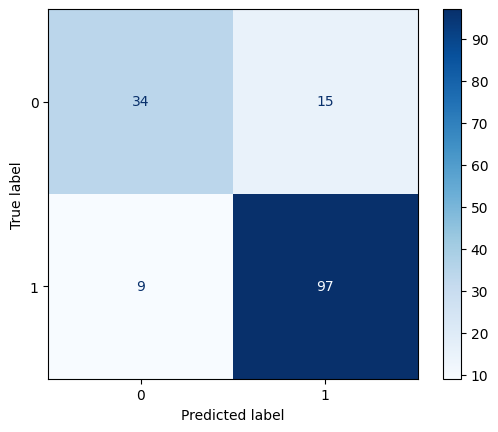

"\nfor set knots: \nBest Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}\naccuracy: 0.84\n"

In [7]:
# Print results 
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
#plt.savefig('./outputs/classifier/binary/2y_confusion_matrix')
plt.show()

'''
for set knots: 
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
accuracy: 0.84
'''

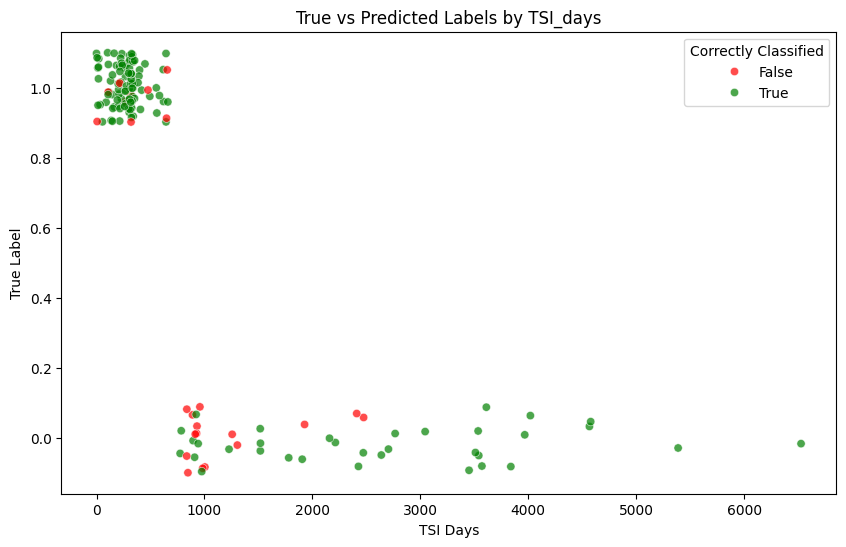

In [8]:
# Create a DataFrame with true and predicted labels, and TSI_days
results_df = test_features[['TSI_days']].copy()
results_df['True Label'] = y_test
results_df['Predicted Label'] = y_pred
results_df['Correctly Classified'] = results_df['True Label'] == results_df['Predicted Label']

# Offset true labels slightly for better visualization
results_df['True Label Offset'] = results_df['True Label'] + np.random.uniform(-0.1, 0.1, size=results_df.shape[0])

# Plot the correctly and incorrectly classified samples against TSI_days
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='TSI_days', y='True Label Offset', hue='Correctly Classified', palette=['red', 'green'], alpha=0.7)
plt.title('True vs Predicted Labels by TSI_days')
plt.xlabel('TSI Days')
plt.ylabel('True Label')
plt.legend(title='Correctly Classified')
plt.show()

# 3 - LOOCV

In [9]:
# Initialize the model with the best parameters
best_rf_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)

# Features and target variable for the combined dataset
X = combined[features_derived]
y = combined['recency']

# Perform LOOCV
loo = LeaveOneOut()
loo_scores = cross_val_score(best_rf_model, X, y, cv=loo, scoring='accuracy', n_jobs=-1)

# Calculate the mean accuracy and confidence interval
mean_accuracy = np.mean(loo_scores)
conf_interval = np.percentile(loo_scores, [2.5, 97.5])

print(f"LOOCV Mean Accuracy: {mean_accuracy:.4f}")
print(f"LOOCV 95% Confidence Interval: {conf_interval}")

'''
FOR SET KNOTS: 
LOOCV Mean Accuracy: 0.8247
LOOCV 95% Confidence Interval: [0. 1.]
'''

LOOCV Mean Accuracy: 0.8310
LOOCV 95% Confidence Interval: [0. 1.]


'\nFOR SET KNOTS: \nLOOCV Mean Accuracy: 0.8247\nLOOCV 95% Confidence Interval: [0. 1.]\n'

# WITH BSPLINE COEFFICIENTS

In [3]:
train = pd.read_csv('./data/derived/bspline_coeffs/training_data_with_bspline_coeffs.csv', index_col=0)
test = pd.read_csv('./data/derived/bspline_coeffs/test_data_with_bspline_coeffs.csv', index_col=0)
combined = pd.concat([train, test])

#DEFINE RECENCY
years = 2
recency_threshold = (years*12) * 30.44

In [5]:
features_derived = ['genome_lrtt', 'genome_tips', 'gag_lrtt', 'gag_tips', 'pol_lrtt', 'pol_tips', 'gp120_lrtt', 'gp120_tips', 'genome_maf12c', 'genome_maf3c', 'gag_maf12c', 'gag_maf3c', 'pol_maf12c', 'pol_maf3c', 'gp120_maf12c', 'gp120_maf3c', 'gp41_maf3c',
                    'lrtt_coeff_0', 'lrtt_coeff_1', 'lrtt_coeff_2', 'lrtt_coeff_3', 'lrtt_coeff_4', 'lrtt_coeff_5', 'lrtt_coeff_6', 'lrtt_coeff_7', 'lrtt_coeff_8', 'lrtt_coeff_10', 'lrtt_coeff_11', 
                    'maf12c_coeff_0', 'maf12c_coeff_1', 'maf12c_coeff_2', 'maf12c_coeff_3', 'maf12c_coeff_5', 'maf12c_coeff_6', 'maf12c_coeff_7', 'maf12c_coeff_9', 'maf12c_coeff_10', 'maf12c_coeff_11',
                    'maf3c_coeff_0', 'maf3c_coeff_1', 'maf3c_coeff_3', 'maf3c_coeff_4', 
                    'genome_ambig', 'gag_ambig', 'pol_ambig', 'gp41_ambig', 'gp120_ambig']

# Label the data
train['recency'] = np.where(train['TSI_days'] <= recency_threshold, 1, 0)
test['recency'] = np.where(test['TSI_days'] <= recency_threshold, 1, 0)

# Features and target variable for training and testing sets
X_train = train[features_derived]
y_train = train['recency']
X_test = test[features_derived]
y_test = test['recency']

## parameter tuning

In [6]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=StratifiedKFold(n_splits=5),
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
380 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.74        49
           1       0.87      0.90      0.88       106

    accuracy                           0.84       155
   macro avg       0.82      0.81      0.81       155
weighted avg       0.84      0.84      0.84       155



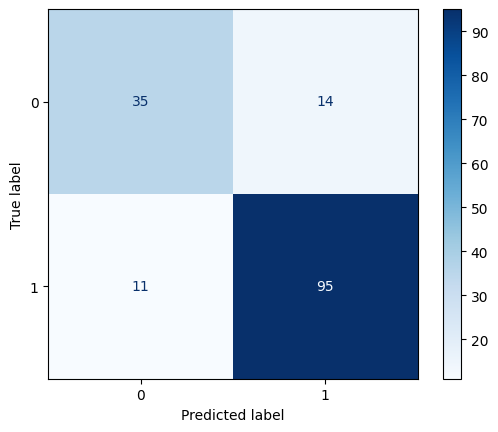

In [7]:
# Print results 
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(class_report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
#plt.savefig('./outputs/classifier/binary/2y_confusion_matrix')
plt.show()